# Beijing Air Quality

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Andrea Dotti `andrea.dotti4@studio.unibo.it`

Giacomo Pierbattista `giacomo.pierbattista@studio.unibo.it`

Citazioni
 - Dataset originario:
  
  Beijing Multi-Site Air-Quality Data
 (https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data)
 
NOTA: Tale dataset consiste in un file .zip, che a sua volta contiene un altro file .zip nel quale si trovano i file .csv con i dati. 
 
Tale file .zip, per semplicità, è stato estratto manualmente dal file .zip originale, rinominato in "Datasets.zip" e caricato su GitHub per semplificare le operazioni di caricamento dei file.

## Descrizione del problema e analisi esplorativa

Si vuole realizzare un modello che, utilizzando i dati climatici e sull'inquinamento registrati da alcuni sensori posti in alcuni distretti di Pechino/Beijing, sia in grado di prevedere con una buona accuratezza l'andamento della temperatura per monitorare come l'inquinamento influisce sul surriscaldamento globale e sul cambiamento climatico.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [1]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Caricamento dei dati

In [2]:
file_zip_url = "https://raw.githubusercontent.com/jackprb/beijing-air-quality/master/datasets.zip"
file_zip_name = "datasets.zip"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [3]:
# short names for Beijing districts
dict_names = {"Ao" : "Aotizhongxin", 
      "Chang" : "Changping",
      "Ding" : "Dingling",
      "Dong" : "Dongsi",
      "Guan" : "Guanyuan",
      "Guc" : "Gucheng",
      "Hua" : "Huairou",
      "Nong" : "Nongzhanguan",
      "Shu" : "Shunyi",
      "Tia" : "Tiantan",
      "Wanl" : "Wanliu",
      "Wans" : "Wanshouxigong"
     }

data_all = []
for name in dict_names.values():
    with open("PRSA_Data_" + name + "_20130301-20170228.csv") as dataFile:
        data_all.append(pd.read_csv(dataFile, sep=","))

data_all = pd.concat(data_all)

Di seguito sono riportate le dimensioni in memoria e il tipo delle feature
che compongono i dati del dataset, comprensivo di _tutti_ i 12 file csv.

In [4]:
data_all.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 104.5 MB


### Prima fase di pulizia e riorganizzazione dei dati

Si nota che nel dataset originario, data e ora del rilevamento vengono memorizzate in 4 colonne distinte (year, month, day, hour).
Abbiamo deciso di unire tali colonne con un'unica nuova feature chiamata `date` che diventerà il nuovo indice.

Abbiamo rimosso la feature `No` (numero progressivo dei rilevamenti), in quanto non rilevante; 

abbiamo anche convertito le variabili nominali della direzione del vento (feature `wd`) nei corrispettivi angoli, come sotto specificato. 

Inoltre abbiamo aggiunto la colonna `weekday` che indica il giorno della settimana (0 = Lunedì, ... , 6 = Domenica) come feature aggiuntiva.

In [5]:
data_all.insert(0, 'date','')
data_all['date'] = pd.to_datetime(data_all[['year', 'month', 'day', 'hour']])
data_all.set_index('date', inplace=True)
data_all.drop(['No'], axis=1, inplace=True)

# definisce mapping delle possibili direzioni del vento con angoli corrispondenti e lo applica al dataframe
wind_direction_mapping = { 'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
                          'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5 } 
data_all['wd'] = data_all['wd'].map(wind_direction_mapping)

data_all['weekday'] = data_all.index.dayofweek
data_all.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,weekday
date,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,337.5,4.4,Aotizhongxin,4
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,0.0,4.7,Aotizhongxin,4
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,337.5,5.6,Aotizhongxin,4
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,315.0,3.1,Aotizhongxin,4
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,0.0,2.0,Aotizhongxin,4
2013-03-01 05:00:00,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,0.0,3.7,Aotizhongxin,4
2013-03-01 06:00:00,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,22.5,2.5,Aotizhongxin,4
2013-03-01 07:00:00,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,337.5,3.8,Aotizhongxin,4
2013-03-01 08:00:00,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,337.5,4.1,Aotizhongxin,4


### Matrice di correlazione delle feature


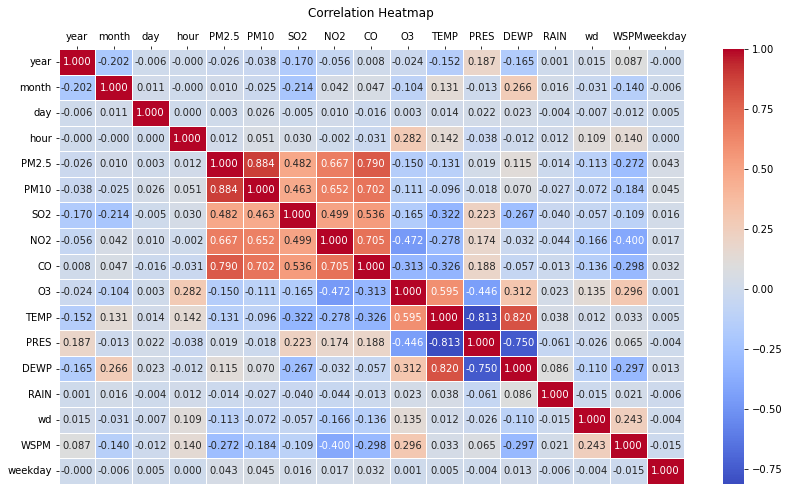

In [6]:
correlation_matrix = data_all.corr(method="pearson")
plt.figure(figsize=(14, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5) 
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Correlation Heatmap', pad=15) 
plt.show()

Analizzando il grafico heatmap sopra notiamo che:
 - i valori di `PM2.5`, `PM10`, `NO2` e `CO` sono molto correlati tra loro (coefficiente > 0.7)
 - essi sono correlati, in modo minore, anche con i valori di `SO2` (coefficiente > 0.5)
 - i valori della temperatura `TEMP` sono correlati con i valori di `O3` (coefficiente 0.6) e con `DEWP` (punto di rugiada)
 - la pressione atmosferica `PRES` è inversamente correlata con la temperatura `TEMP` e con il punto di rugiada `DEWP` (coefficiente -0.8).
 
Ora andremo a testare le performance di alcuni modelli **mantenendo** tutte le feature mostrate nel grafico qui sopra per trovare il modello più accurato.

Successivamente testeremo tale modello **rimuovendo** le feature considerate meno rilevanti dalla matrice di Pearson.

### Significato delle feature

Si riporta la descrizione delle feature dal dataset originale: 

https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

`date`: data e ora del rilevamento (indice del dataframe)

`year`: anno del rilevamento 

`month`: mese del rilevamento

`day`: giorno del rilevamento

`hour`: ora del rilevamento

`PM2.5`: concentrazione di PM2.5 in ${\mu g}/{m^3}$

`PM10`: concentrazione di PM10 in ${\mu g}/{m^3}$

`SO2`: concentrazione di SO2 in ${\mu g}/{m^3}$

`NO2`: concentrazione di NO2 in ${\mu g}/{m^3}$

`CO`: concentrazione di CO in ${\mu g}/{m^3}$

`O3`: concentrazione di O3 in ${\mu g}/{m^3}$

`TEMP`: temperatura in gradi Celsius `°C`

`PRES`: pressione in `hPa`

`DEWP`: temperatura del punto di rugiata in gradi Celsius `°C`

`RAIN`: `mm` di pioggia caduti

`wd`: direzione del vento, angolo espresso in gradi (da 0° a 360°)

`WSPM`: velocità del vento in `m/s`

`station`: nome della località dove sono stati rilevati i dati

`weekday`: giorno della settimana (0 = Lunedì, ... , 6 = Domenica)

### Esplorazione delle feature

E' possibile visualizzare media, deviazione standard e la distribuzione in termini di massimi, minimi e percentili per le colonne con valori numerici utilizzando il metodo `describe()`.

Con il metodo `.T` si ottiene il dataframe trasposto, in modo da avere il dataframe visibile per intero, senza la necessità delle barre di scorrimento orizzontali.

In [7]:
data_all.describe().T

,count,mean,std,min,25%,50%,75%,max
year,420768.0,2014.662560,1.177198,2013.0000,2014.00,2015.0,2016.00,2017.0
month,420768.0,6.522930,3.448707,1.0000,4.00,7.0,10.00,12.0
day,420768.0,15.729637,8.800102,1.0000,8.00,16.0,23.00,31.0
hour,420768.0,11.500000,6.922195,0.0000,5.75,11.5,17.25,23.0
PM2.5,412029.0,79.793428,80.822391,2.0000,20.00,55.0,111.00,999.0
PM10,414319.0,104.602618,91.772426,2.0000,36.00,82.0,145.00,999.0
SO2,411747.0,15.830835,21.650603,0.2856,3.00,7.0,20.00,500.0
NO2,408652.0,50.638586,35.127912,1.0265,23.00,43.0,71.00,290.0
CO,400067.0,1230.766454,1160.182716,100.0000,500.00,900.0,1500.00,10000.0
O3,407491.0,57.372271,56.661607,0.2142,11.00,45.0,82.00,1071.0


Poiché le temperature in gradi Celsius (°C) oscillano tra valori positivi e negativi, ciò potrebbe causare dei problemi nel calcolo dell'errore relativo, in quanto si avrebbe una divisione con denominatore zero.
Di conseguenza, abbiamo deciso di convertire le temperature da gradi Celsius in gradi Kelvin (K), secondo la relazione

$T_K = T_C + 273.15 K$

in cui $T_K$ è la temperatura in gradi Kelvin (K)
e $T_C$ è la temperatura in gradi Celsius (°C)

In [8]:
data_all['TEMP'] = data_all['TEMP'].apply(lambda x: x + 273.15)
data_all['DEWP'] = data_all['DEWP'].apply(lambda x: x + 273.15)
data_all

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,weekday
date,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,272.45,1023.0,254.35,0.0,337.5,4.4,Aotizhongxin,4
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,272.05,1023.2,254.95,0.0,0.0,4.7,Aotizhongxin,4
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,272.05,1023.5,254.95,0.0,337.5,5.6,Aotizhongxin,4
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,271.75,1024.5,253.75,0.0,315.0,3.1,Aotizhongxin,4
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,271.15,1025.2,253.65,0.0,0.0,2.0,Aotizhongxin,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,285.65,1013.5,256.95,0.0,315.0,2.4,Wanshouxigong,1
2017-02-28 20:00:00,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,284.75,1013.6,258.05,0.0,292.5,0.9,Wanshouxigong,1
2017-02-28 21:00:00,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,283.95,1014.2,259.85,0.0,315.0,1.1,Wanshouxigong,1


Con i metodi `isnull().sum(0)` si contano i valori mancanti nel dataset per righe.

Tale risultato viene poi ordinato in senso decrescente per visualizzare quali features hanno più dati mancanti.

In [9]:
data_missing_general = data_all.isnull().sum(0).sort_values(ascending=False)
data_missing_general

CO         20701
O3         13277
NO2        12116
SO2         9021
PM2.5       8739
PM10        6449
wd          1822
DEWP         403
TEMP         398
PRES         393
RAIN         390
WSPM         318
station        0
year           0
month          0
hour           0
day            0
weekday        0
dtype: int64

Rappresentiamo il risultato appena ottenuto in un grafico a barre

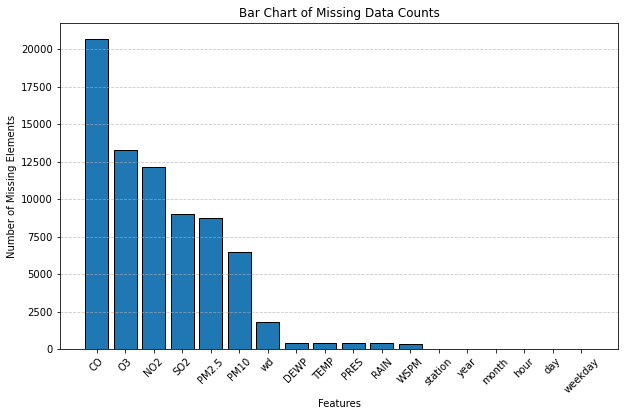

In [10]:
plt.figure(figsize=(10, 6)) 
plt.bar(data_missing_general.index, data_missing_general, edgecolor='k') 
plt.xlabel('Features'); plt.ylabel('Number of Missing Elements') 
plt.title('Bar Chart of Missing Data Counts') 
plt.xticks(rotation=45) # ruota etichette di asse x per leggibilità maggiore
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

Si osserva che le prime 6 features con più dati mancanti sono:
 1. CO
 2. O3
 3. NO2
 4. SO2
 5. PM2.5
 6. PM10
 
Notare che le PM2.5 e le PM10 sono comunemente note come, rispettivamente, "polveri sottili" e "particolato" e
costituiscono i principali inquinanti nelle aree urbane.

Il grafico seguente mostra l'andamento medio delle temperature durante il periodo di rilevamento. 
#### (grafico *)

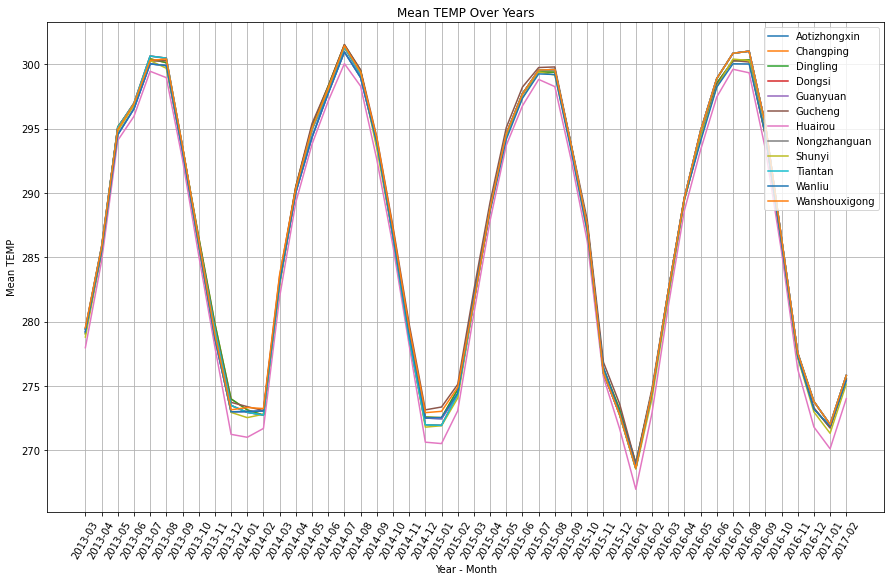

In [11]:
def plotMeanFeatureByDate(feature_name, df_name):
    # Group the data by cities and year, and calculate mean 'feature_name' for each group
    grouped = df_name.groupby(['station', df_name.index.strftime("%Y-%m")])[feature_name].mean().reset_index()

    # Create a Matplotlib figure and axis
    plt.figure(figsize=(15, 9))

    # Plot mean 'feature_name' values over years for each city
    for city, group in grouped.groupby('station'):
        plt.plot(group['date'], group[feature_name], label=city)

    plt.xticks(grouped['date'].unique())
    plt.title('Mean ' + feature_name + ' Over Years')
    plt.xlabel('Year - Month')
    plt.ylabel('Mean ' + feature_name)
    plt.xticks(rotation=60) # ruota etichette di asse x per leggibilità maggiore
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1)) 
    plt.grid(True)
    plt.show()   

# sostituire TEMP con il nome di una feature per visualizzare il grafico di 
# tale feature per tutte le zone di Pechino/Beijing
plotMeanFeatureByDate("TEMP", data_all);

Raggruppiamo i dati per zona di rilevamento (feature `station`) e visualizziamo la percentuale di dati mancanti per la feature temperatura (`TEMP`), attraverso un diagramma a torta.

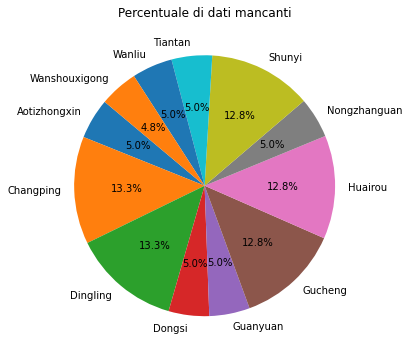

station
Wanshouxigong    19
Aotizhongxin     20
Dongsi           20
Guanyuan         20
Nongzhanguan     20
Tiantan          20
Wanliu           20
Gucheng          51
Huairou          51
Shunyi           51
Changping        53
Dingling         53
Name: TEMP, dtype: int64

In [12]:
data_missing = data_all.groupby('station')['TEMP'].apply(lambda x: x.isnull().sum())
# mostra numero totale di dati mancanti per ogni feature e per ogni zona di Beijing

plt.figure(figsize=(6, 6)) 
plt.pie(data_missing, labels=data_all['station'].unique(), autopct='%1.1f%%', startangle=140) 
plt.title('Percentuale di dati mancanti') 
plt.show()

data_missing.sort_values()

Di seguito andremo a riempire i **dati mancanti (Nan)** con il metodo `fillna()`, sostituendoli con il valore dell'ultima rilevazione non nulla, anzichè la sostituzione con il valore medio, in quanto ci aspettiamo che tale sostituzione funzioni  bene su questa serie temporale di rilevazioni.

In [13]:
data_ffilled = data_all.fillna(method="ffill")
data_ffilled.isnull().sum()

year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
weekday    0
dtype: int64

Definiamo il dataset `data_wan` riferito alla località Wanshou Xigong, poiché è la zona con meno valori mancanti.

In [14]:
data_wan = data_ffilled.loc[data_ffilled['station'] == 'Wanshouxigong', data_ffilled.columns != 'station']
data_wan

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,weekday
date,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,273.45,1021.9,254.15,0.0,292.5,2.0,4
2013-03-01 01:00:00,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,273.05,1022.4,253.85,0.0,292.5,4.4,4
2013-03-01 02:00:00,2013,3,1,2,8.0,8.0,7.0,16.0,200.0,59.0,272.55,1022.6,253.45,0.0,292.5,4.7,4
2013-03-01 03:00:00,2013,3,1,3,8.0,8.0,3.0,16.0,200.0,59.0,272.45,1023.5,252.25,0.0,315.0,2.6,4
2013-03-01 04:00:00,2013,3,1,4,8.0,8.0,3.0,16.0,300.0,36.0,272.25,1024.1,251.45,0.0,292.5,2.5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,285.65,1013.5,256.95,0.0,315.0,2.4,1
2017-02-28 20:00:00,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,284.75,1013.6,258.05,0.0,292.5,0.9,1
2017-02-28 21:00:00,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,283.95,1014.2,259.85,0.0,315.0,1.1,1


### Divisione dei dati in training set e validation set

Al dataset `data_wan` rimuoviamo la feature da predire, cioè `TEMP` e otteniamo le variabili X e y che contengono, rispettivamente, i valori di tutte le feature indipendenti e i valori della feature da predire (dipendente).

Successivamente, con il metodo `train_test_split`, dividiamo il contenuto delle variabili X e y in modo random tra il training e il validation set.

In [15]:
y = data_wan['TEMP']
X = data_wan.drop(['TEMP'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

Definiamo le funzioni per 
 - calcolare l'errore relativo 
 - visualizzare le valutazioni di un modello
 - ottenere le predizioni

In [16]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval_all(X_train, y_train, X_val, y_val, model):
    print(f"   ----------Training----------")
    res_train = print_eval(X_train, y_train, model)
    print(f"\n   --------Validation----------")
    res_val   = print_eval(X_val, y_val, model)
    return res_val
    
def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")
    return [mse, re, r2]
    
def print_coeff_intercept(X, model):
    print(f"\nCoefficient(s):\n{ pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)}")
    print(f"\nIntercept: {model.intercept_}")
    
def print_coeff_intercept_gs(gs, gs_step_name, X):
    best = gs.best_estimator_.named_steps[gs_step_name] 
    coeffs = best.coef_[:X.shape[1]]
    coeffs = pd.Series(coeffs, index=X.columns ).sort_values(ascending=False)
    print(f"\nCoefficient(s):\n{coeffs}")
    print(f"\nIntercept: {best.intercept_}")

Definiamo una funzione generale per mostrare un grafico che visualizza l'andamento di una feature di una città e l'andamento della stessa feature restituita dal modello specificato.

Essendo una regressione multivariata, è impossibile rappresentare in un grafico tutte le feature.
Abbiamo scelto di mostrare

    sull'asse x le date raggruppate per mesi, 
    mentre sull'asse y le medie dei valori della feature in quel mese (sia per la città, sia quelli predetti dal modello).

Il grafico rappresenta i dati in modo approssimativo in quanto mostra le medie mensili, non l'andamento effettivo giornaliero della feature specificata, poiché avremmo ottenuto un grafico poco leggibile.

In [17]:
def plotMeanFeatureByDateAndCity(feature_name, df_name, city_name, model_df = None):
    # Group the data by cities and year, and calculate mean 'feature_name' for each group
    grouped = df_name.groupby(df_name.index.strftime("%Y-%m"))[feature_name].mean()
    grouped = pd.DataFrame(grouped, index=grouped.index)
    
    # Create a Matplotlib figure and axis
    plt.figure(figsize=(15, 9))

    # Plot mean 'feature_name' values over years for each city
    plt.plot(grouped.index, grouped[feature_name], color='blue', label=city_name)

    if model_df is not None:
        grouped = model_df.groupby(model_df.index.strftime("%Y-%m"))[feature_name].mean()
        grouped = pd.DataFrame(grouped, index=grouped.index)
        plt.plot(grouped.index, grouped[feature_name], color='red', label="Model prediction")
    
    # Customize the plot
    plt.title('Mean ' + feature_name + ' Over Years')
    plt.xlabel('Year - Month')
    plt.ylabel('Mean ' + feature_name)
    plt.xticks(rotation=60) # ruota etichette di asse x per leggibilità maggiore
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1)) 
    plt.grid(True)
    
    # Display the plot
    plt.show()   
    
def getPredictions(X, model):
    preds = model.predict(X) 
    results = pd.DataFrame(preds, index=X.index, columns=["TEMP"]) 
    return results

## Addestramento, validazione e ricerca degli iperparametri

Abbiamo deciso di provare per gradi quale modello sia il più adatto e accurato per il nostro contesto.

### Regressione lineare semplice

Creiamo un modello di regressione lineare semplice e lo addestriamo con il dataset di training `X_train` e `y_train`, ottenuto dalla divisione **random** dei dati con la funzione `train_test_split` di Scikit Learn.

   ----------Training----------
   Mean squared error: 14.685
       Relative error: 1.05512%
R-squared coefficient: 0.88693

   --------Validation----------
   Mean squared error: 14.48
       Relative error: 1.04421%
R-squared coefficient: 0.88791

Coefficient(s):
WSPM       1.145757
DEWP       0.444535
year       0.182615
month      0.143813
hour       0.073581
O3         0.046686
NO2        0.026735
weekday    0.011154
SO2        0.007338
day        0.005571
PM10       0.002693
CO        -0.001362
wd        -0.001392
PM2.5     -0.013192
PRES      -0.333290
RAIN      -0.555606
dtype: float64

Intercept: 128.3510780313159


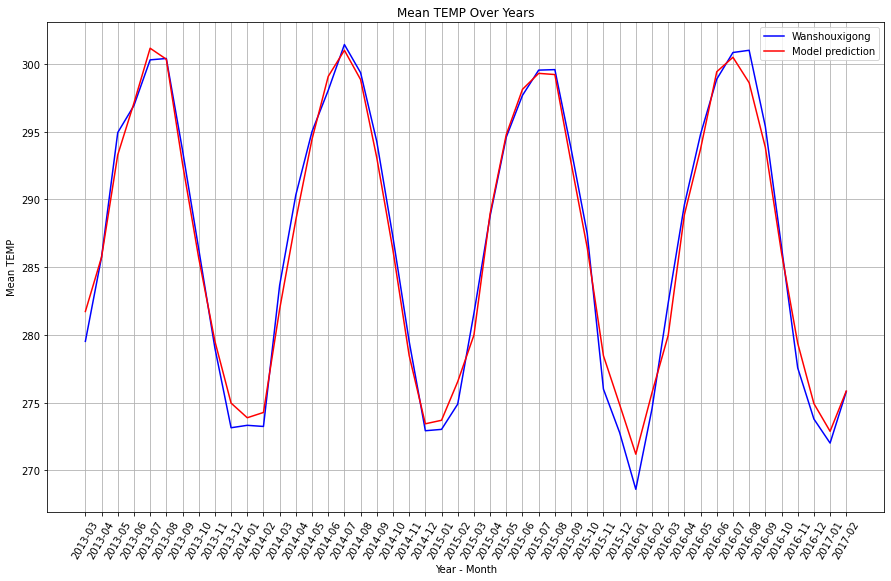

In [18]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
resLrm1 = print_eval_all(X_train, y_train, X_val, y_val, lrm)
print_coeff_intercept(X_train, lrm)

# otteniamo le predizioni del modello, le inseriamo in un dataframe e 
# disegnamo il grafico delle predizioni sovrapposto al grafico dei dati noti
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, lrm)) 

Abbiamo ottenuto risultati abbastanza accurati, seppur utilizzando un modello di regressione lineare semplice.

Controllando i coefficienti assegnati alle feature dal modello, si nota che, inaspettatamente, è stata data molta importanza alla velocità del vento (feature `WSPM`), mentre, come previsto, è stata data una certa importanza alla feature `DEWP`, indicante il punto di rugiada.


Ora creiamo un altro modello di **regressione lineare semplice** in cui utilizziamo la **suddivisione temporale tra training e validation set**.

In [19]:
is_trainDate = (data_wan.index.year < 2015) | ((data_wan.index.year == 2015) & (data_wan.index.month <= 2))
X_train_date = data_wan.loc[is_trainDate, data_wan.columns != 'TEMP']
y_train_date = data_wan.loc[is_trainDate, "TEMP"]
X_val_date = data_wan.loc[~is_trainDate, data_wan.columns != 'TEMP']
y_val_date = data_wan.loc[~is_trainDate, "TEMP"]

   ----------Training----------
   Mean squared error: 15.02
       Relative error: 1.06821%
R-squared coefficient: 0.87956

   --------Validation----------
   Mean squared error: 15.83
       Relative error: 1.09154%
R-squared coefficient: 0.88237

Coefficient(s):
WSPM       1.531264
DEWP       0.464042
year       0.451555
month      0.212806
hour       0.062444
O3         0.041529
weekday    0.030381
NO2        0.025931
SO2        0.014697
day        0.001482
PM10      -0.000352
CO        -0.001468
wd        -0.005268
PM2.5     -0.010807
PRES      -0.313022
RAIN      -0.710143
dtype: float64

Intercept: -438.74586562747004


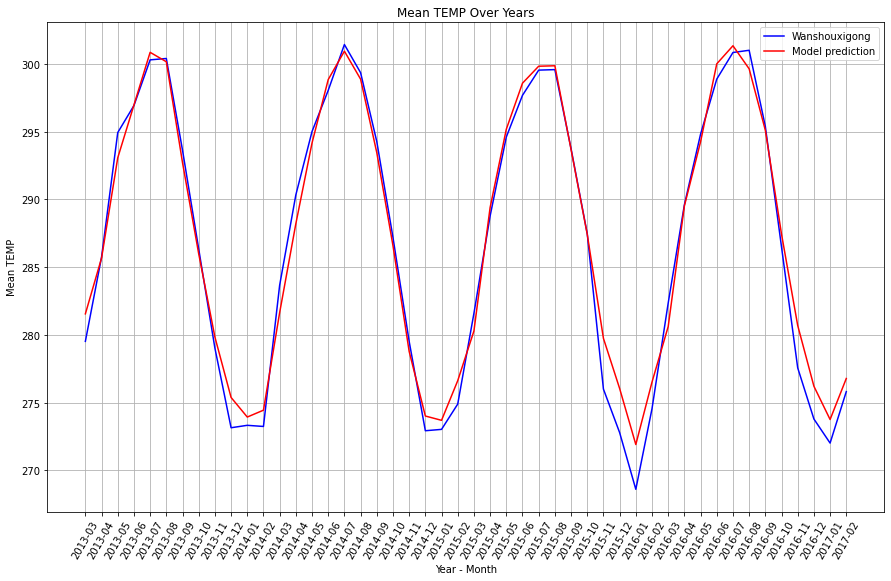

In [20]:
lrm2 = LinearRegression()
lrm2.fit(X_train_date, y_train_date)
resLrm2 = print_eval_all(X_train_date, y_train_date, X_val_date, y_val_date, lrm2)
print_coeff_intercept(X_train_date, lrm2)

# otteniamo le predizioni del modello, le inseriamo in un dataframe e 
# disegnamo il grafico delle predizioni sovrapposto al grafico dei dati noti
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, lrm2))

Si può notare che, anche in questo caso, l'accuratezza di quest'ultimo modello è molto simile al risultato ottenuto dalla divisione random del dataset attraverso `train_test_split` di Scikit Learn.

### Regressione lineare semplice con Standard Scaler

Ora proviamo a creare un nuovo modello di regressione lineare, utilizzando le `Pipeline`, in cui applichiamo anche la standardizzazione delle feature con lo `StandardScaler()`.
Prima utilizziamo il dataset **diviso in modo casuale** (`X_train` e `y_train`).

   ----------Training----------
   Mean squared error: 14.685
       Relative error: 1.05512%
R-squared coefficient: 0.88693

   --------Validation----------
   Mean squared error: 14.48
       Relative error: 1.04421%
R-squared coefficient: 0.88791

Coefficient(s):
DEWP       6.081454
O3         2.673603
WSPM       1.382666
NO2        0.964755
hour       0.509594
month      0.496636
PM10       0.268975
year       0.214615
SO2        0.176949
day        0.049115
weekday    0.022352
wd        -0.141091
RAIN      -0.411325
PM2.5     -1.152864
CO        -1.709837
PRES      -3.521700
dtype: float64

Intercept: 286.88413325667074


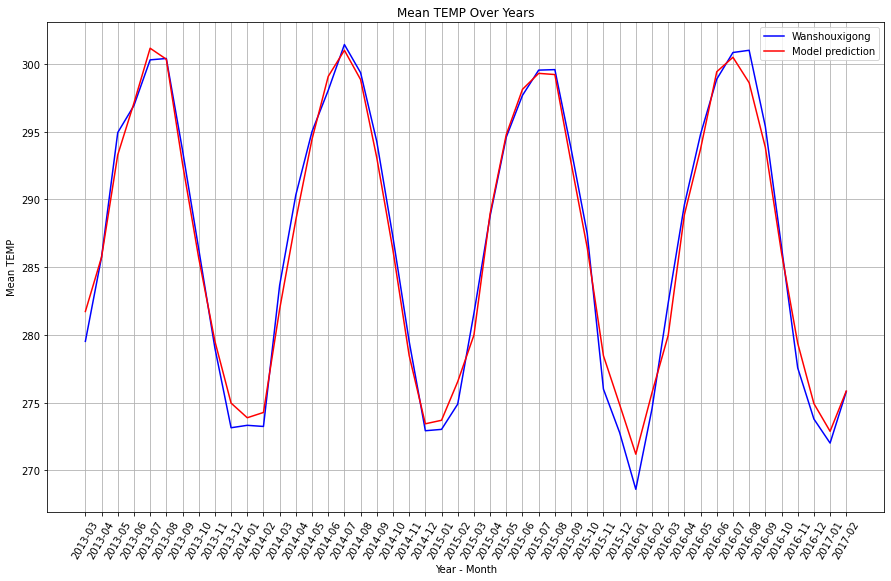

In [21]:
model1a = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model1a.fit(X_train, y_train)
resModel1a = print_eval_all(X_train, y_train, X_val, y_val, model1a)
print_coeff_intercept(X_train, model1a.named_steps['regr'])
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, model1a))

Ora utilizziamo il **dataset diviso temporalmente**.

   ----------Training----------
   Mean squared error: 15.02
       Relative error: 1.06821%
R-squared coefficient: 0.87956

   --------Validation----------
   Mean squared error: 15.83
       Relative error: 1.09154%
R-squared coefficient: 0.88237

Coefficient(s):
DEWP       6.404359
O3         2.354378
WSPM       1.787127
NO2        0.966334
month      0.733722
SO2        0.433431
hour       0.432251
year       0.280370
weekday    0.060731
day        0.013034
PM10      -0.035207
RAIN      -0.445951
wd        -0.508190
PM2.5     -0.901134
CO        -1.729464
PRES      -3.263669
dtype: float64

Intercept: 287.0035616438356


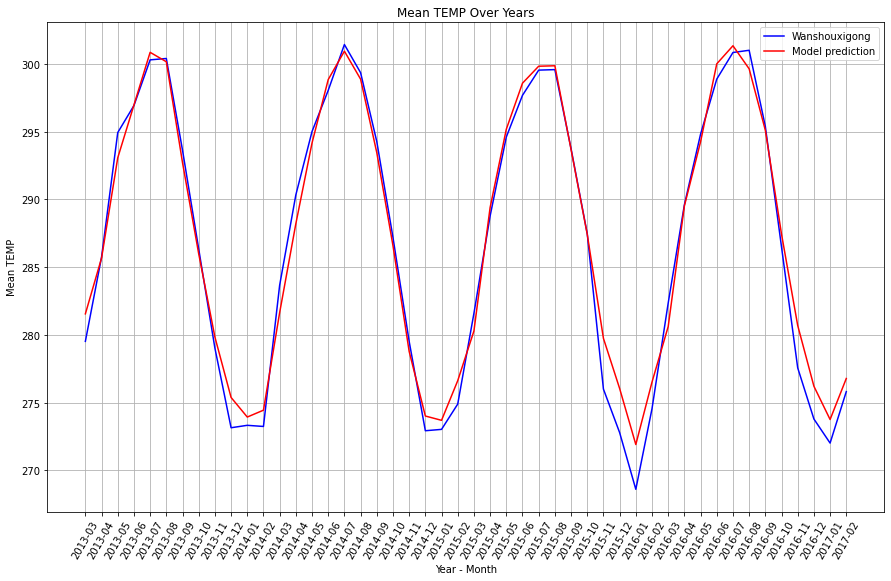

In [22]:
model1b = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model1b.fit(X_train_date, y_train_date)
resModel1b = print_eval_all(X_train_date, y_train_date, X_val_date, y_val_date, model1b)
print_coeff_intercept(X_train_date, model1b.named_steps['regr'])
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, model1b))

Anche in questo caso, i coefficienti $R^2$ rimangono attorno a 0.88, mentre gli errori relativi e i MSE rimangono ancora relativamente bassi, attorno all' 1%.

### Regressione lineare con Polynomial Features
Proviamo ad aumentare l'accuratezza introducendo le `PolynomialFeatures`, utilizzando la `GridSearchCV` per trovare il valore ottimale degli iperparametri, utilizzando il **dataset con dati divisi in modo random dal KFold**.

In [23]:
kf = KFold(5, shuffle=True, random_state=42)

In [24]:
%%time
model2a = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
grid = {
    "poly__degree": [2,3] 
    # abbiamo rimosso il grado 4 per ridurre i tempi di addestramento, durante i test non è stato mai scelto
}
gs = GridSearchCV(model2a, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print("best params:", gs.best_params_, "\n")
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

best params: {'poly__degree': 2} 

CPU times: total: 27 s
Wall time: 8.54 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.156739,0.000985,0.015616,0.009876,2,{'poly__degree': 2},0.932596,0.941192,0.939569,0.939639,0.934854,0.937570,0.003272,1
1,1.427226,0.037072,0.062500,0.000007,3,{'poly__degree': 3},-1.454329,0.956073,0.933046,0.896609,0.848591,0.435998,0.945861,2


Si ottengono i risultati migliori con polinomi di grado 2.

Ora verifichiamo i risultati sui training e validation set separatamente.

   ----------Training----------
   Mean squared error: 7.7411
       Relative error: 0.75184%
R-squared coefficient: 0.9404

   --------Validation----------
   Mean squared error: 7.7878
       Relative error: 0.75053%
R-squared coefficient: 0.93971

Coefficient(s):
WSPM       369.543263
month      350.406520
PM2.5      256.857421
CO         163.806934
year       100.425073
day         39.994703
weekday    -41.009611
RAIN       -75.764640
hour      -158.061635
SO2       -215.474199
NO2       -257.251835
O3        -292.171567
DEWP      -370.747433
PRES      -422.955501
PM10      -467.808763
wd        -530.101491
dtype: float64

Intercept: 286.8841332567919


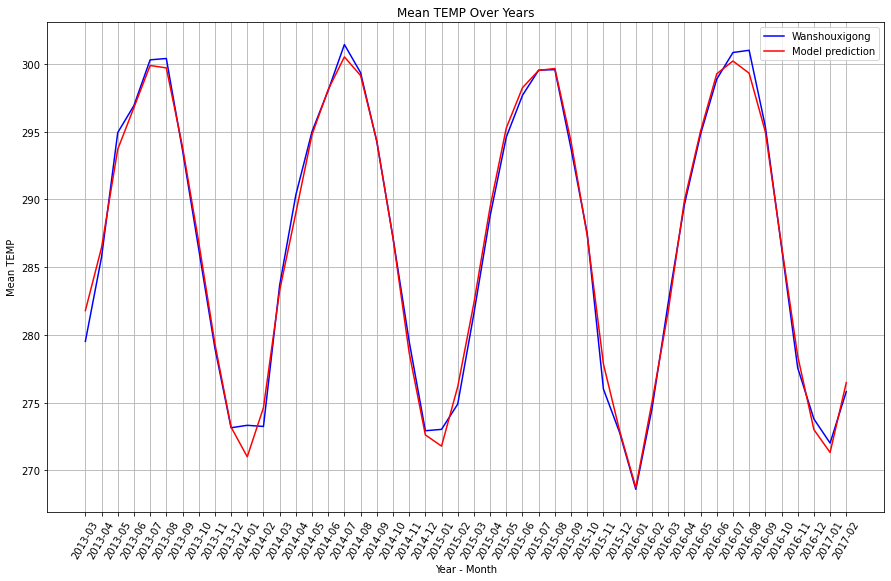

In [25]:
resGs = print_eval_all(X_train, y_train, X_val, y_val, gs.best_estimator_)
print_coeff_intercept_gs(gs, 'regr', X)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs.best_estimator_))

Notiamo che l'accuratezza indicata dal coefficiente $R^2$ è aumentata rispetto ai modelli di regressione lineare semplice.

Ora creiamo un `TimeSeriesSplit` con 3 split e addestriamo un nuovo modello che usa tale `TimeSeriesSplit` come metodo di cross validation, utilizzando i dati divisi temporalmente come dataset di training.

In [26]:
%%time
tss = TimeSeriesSplit(3)

model2b = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
grid = {
    "poly__degree": [2,3]
    # abbiamo rimosso il grado 4 per ridurre i tempi di addestramento, durante i test non è stato mai scelto
}
gs2 = GridSearchCV(model2b, grid, cv=tss, refit=True)
gs2.fit(X_train, y_train)
print("best params:", gs2.best_params_, "\n")
pd.DataFrame(gs2.cv_results_).sort_values("mean_test_score", ascending=False)

best params: {'poly__degree': 2} 

CPU times: total: 12.1 s
Wall time: 3.49 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092294,0.033512,0.014401,0.001726,2,{'poly__degree': 2},0.933521,0.920920,0.937487,0.930643,0.007063,1
1,0.893151,0.279038,0.095997,0.015578,3,{'poly__degree': 3},-28.248299,-3.384305,0.921972,-10.236877,12.856762,2


   ----------Training----------
   Mean squared error: 7.7411
       Relative error: 0.75184%
R-squared coefficient: 0.9404

   --------Validation----------
   Mean squared error: 7.7878
       Relative error: 0.75053%
R-squared coefficient: 0.93971

Coefficient(s):
WSPM       369.543263
month      350.406520
PM2.5      256.857421
CO         163.806934
year       100.425073
day         39.994703
weekday    -41.009611
RAIN       -75.764640
hour      -158.061635
SO2       -215.474199
NO2       -257.251835
O3        -292.171567
DEWP      -370.747433
PRES      -422.955501
PM10      -467.808763
wd        -530.101491
dtype: float64

Intercept: 286.8841332567919


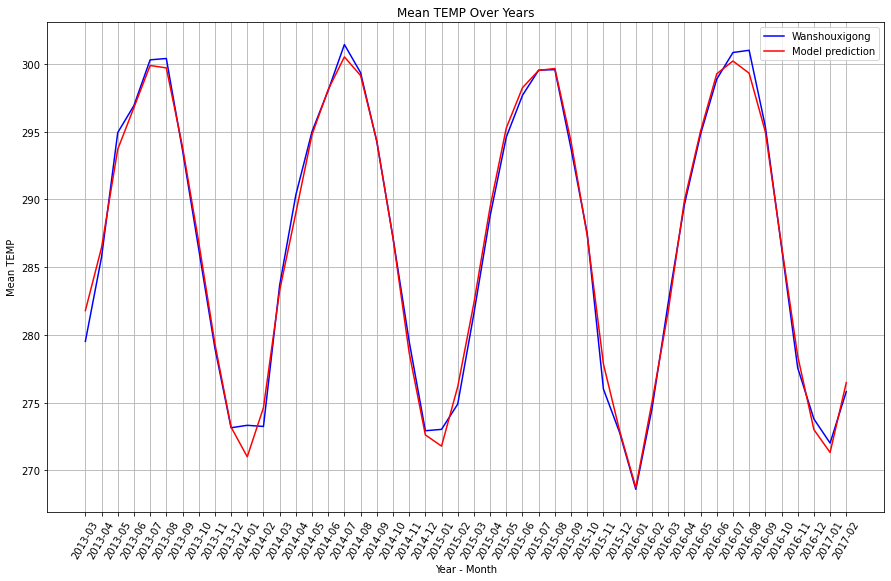

In [27]:
resGs2 = print_eval_all(X_train, y_train, X_val, y_val, gs2.best_estimator_)
print_coeff_intercept_gs(gs2, 'regr', X)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs2.best_estimator_))

Dopo questi test si nota che, dividendo il dataset in modo _random_ con KFold, si ottengono risultati abbastanza accurati e a volte anche leggermente migliori rispetto alla divisione _temporale_ del dataset, nei modelli di regressione lineare semplice con o senza lo `StandardScaler`.

Nei modelli di regressione lineare con `PolynomialFeatures` e `StandardScaler`, invece, si ottengono risultati migliori dividendo il dataset in modo _random_ con KFold.

A seguito di queste valutazioni, abbiamo deciso di addestrare i prossimi modelli solo con la divisione random utilizzando KFold.

### Regressione Ridge con Polynomial Features

In [28]:
%%time
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Ridge())
])
grid = {
    "poly__degree": [2, 3],
    "regr__alpha": [0.01, 0.1, 1],
}
gs3 = GridSearchCV(model, grid, cv=kf, refit=True)
gs3.fit(X_train, y_train);
gs3.best_params_

CPU times: total: 40 s
Wall time: 13.6 s


{'poly__degree': 2, 'regr__alpha': 0.01}

   ----------Training----------
   Mean squared error: 7.8513
       Relative error: 0.75811%
R-squared coefficient: 0.93955

   --------Validation----------
   Mean squared error: 7.9239
       Relative error: 0.75752%
R-squared coefficient: 0.93866

Coefficient(s):
month       72.281524
WSPM        70.340056
day         17.885295
year        -2.928601
weekday     -3.359773
O3         -11.483772
PRES       -14.617240
RAIN       -22.727078
NO2        -30.353712
SO2        -30.791949
DEWP       -38.063526
hour       -42.093497
CO         -44.188460
PM2.5      -56.348897
PM10       -66.102067
wd        -116.875578
dtype: float64

Intercept: 286.8841332566831


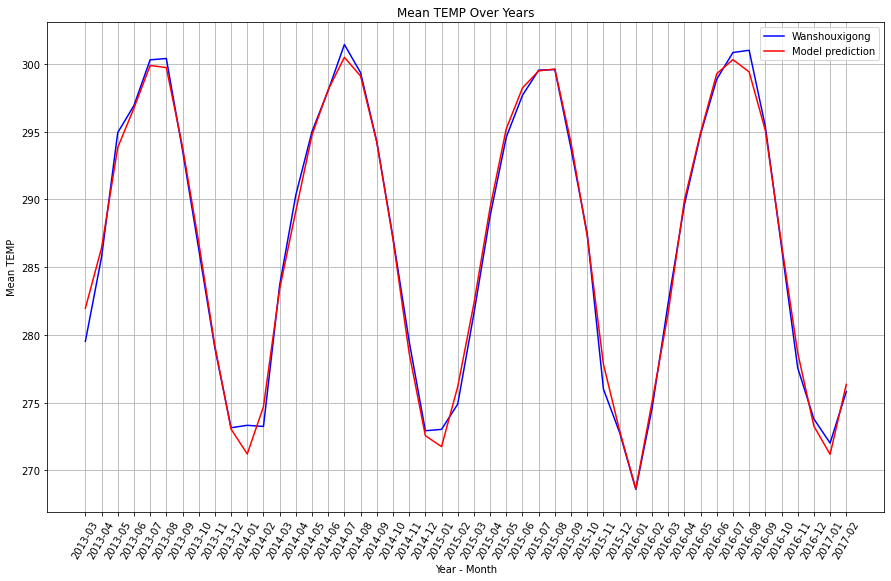

In [29]:
resGs3 = print_eval_all(X_train, y_train, X_val, y_val, gs3.best_estimator_)
print_coeff_intercept_gs(gs3, 'regr', X)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs3.best_estimator_))

#best_ridge = gs3.best_estimator_.named_steps['regr'] 
#ridge_coefficients = best_ridge.coef_[:X.shape[1]] 
#pd.Series(ridge_coefficients, index=X.columns).sort_values(ascending=False)

### Regressione Lasso con Polynomial Features

Ora proviamo a creare un altro modello in cui sostituiamo la regressione Ridge con la regressione Lasso.

In [30]:
%%time
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Lasso())
])
grid = {
    "poly__degree": [2, 3],
    "regr__alpha": [0.01, 0.1],
}
gs4 = GridSearchCV(model, grid, cv=kf, refit=True)
gs4.fit(X_train, y_train);
gs4.best_params_

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.059e+03, tolerance: 2.435e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.020e+03, tolerance: 2.425e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.090e+03, tolerance: 

CPU times: total: 8min 14s
Wall time: 2min 7s


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+04, tolerance: 3.036e+02
  model = cd_fast.enet_coordinate_descent(


{'poly__degree': 3, 'regr__alpha': 0.01}

   ----------Training----------
   Mean squared error: 8.1258
       Relative error: 0.77620%
R-squared coefficient: 0.93743

   --------Validation----------
   Mean squared error: 8.6226
       Relative error: 0.78196%
R-squared coefficient: 0.93325

Coefficient(s):
O3         4.038564
hour       1.811191
DEWP       1.052580
year       0.363105
WSPM       0.361971
month      0.000000
day        0.000000
PM2.5     -0.000000
PM10      -0.000000
SO2        0.000000
NO2       -0.000000
CO        -0.000000
RAIN      -0.000000
wd         0.000000
weekday   -0.000000
PRES      -1.625994
dtype: float64

Intercept: 286.88413325667005


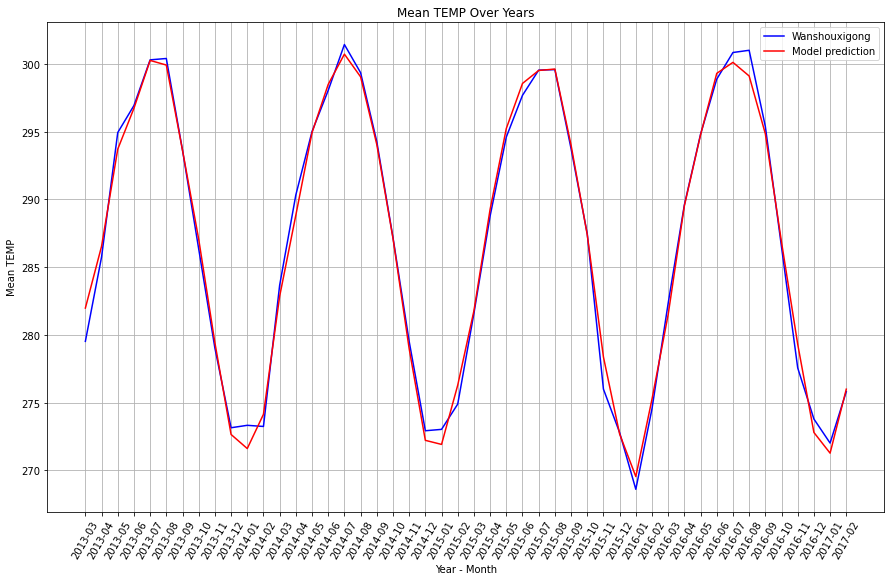

In [31]:
resGs4 = print_eval_all(X_train, y_train, X_val, y_val, gs4.best_estimator_)
print_coeff_intercept_gs(gs4, 'regr', X)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs4.best_estimator_))

#best_lasso = gs4.best_estimator_.named_steps['regr'] 
#lasso_coefficients = best_lasso.coef_[:X.shape[1]] 
#pd.Series(lasso_coefficients, index=X.columns).sort_values(ascending=False)

### Regressione Elastic Net

Infine proviamo a sostituire la regressione Lasso con la regressione Elastic Net, che combina le regressioni Ridge e Lasso.

Nella GridSearch che segue useremo i valori indicati come migliori nei test precedenti.

In [32]:
gs3.best_params_['poly__degree'] == gs4.best_params_['poly__degree']

False

In [33]:
gs3.best_params_['regr__alpha'] == gs4.best_params_['regr__alpha']

True

In [34]:
%%time
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", ElasticNet())
])
degrees = list ( set( [gs3.best_params_['poly__degree'], gs4.best_params_['poly__degree']]) )
alphas =  list ( set( [gs3.best_params_['regr__alpha'],  gs4.best_params_['regr__alpha'] ]) )

grid = {
    "poly__degree": degrees,
    "regr__alpha": alphas,
    "regr__l1_ratio" : [0.7, 0.3],
}
gs5 = GridSearchCV(model, grid, cv=kf, refit=True)
gs5.fit(X_train, y_train);
gs5.best_params_

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e+04, tolerance: 2.435e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e+04, tolerance: 2.425e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+04, tolerance: 

CPU times: total: 9min 58s
Wall time: 2min 34s


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e+04, tolerance: 3.036e+02
  model = cd_fast.enet_coordinate_descent(


{'poly__degree': 3, 'regr__alpha': 0.01, 'regr__l1_ratio': 0.7}

   ----------Training----------
   Mean squared error: 8.0505
       Relative error: 0.77187%
R-squared coefficient: 0.93801

   --------Validation----------
   Mean squared error: 8.7203
       Relative error: 0.77968%
R-squared coefficient: 0.9325

Coefficient(s):
month      1.224430
hour       0.655667
O3         0.476038
WSPM       0.187946
year       0.167930
day        0.000000
PM2.5     -0.000000
PM10       0.000000
SO2        0.000000
NO2       -0.000000
CO        -0.000000
DEWP       0.000000
wd         0.000000
weekday   -0.000000
RAIN      -0.065754
PRES      -0.076465
dtype: float64

Intercept: 286.8841332566705


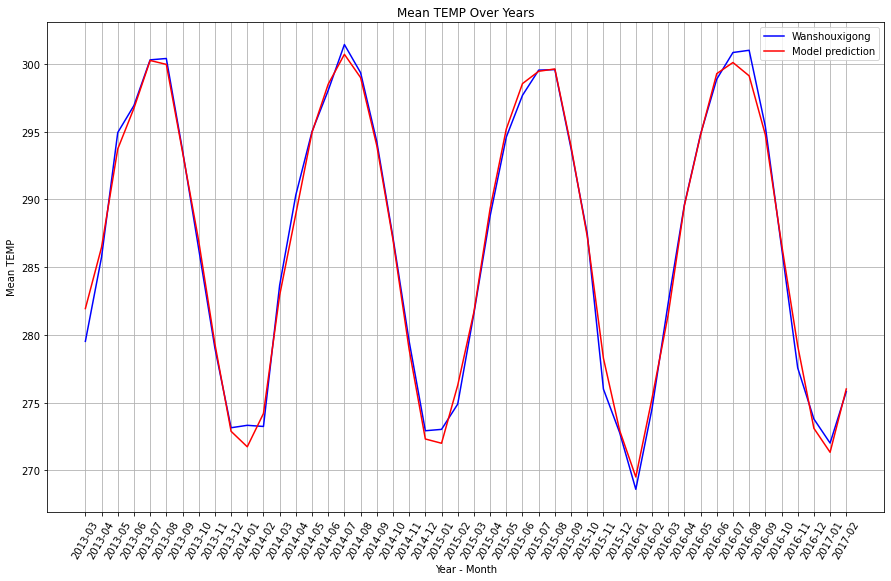

In [35]:
# con l1_ratio = 1 -> LASSO
# con l1_ratio = 0 -> RIDGE

resGs5 = print_eval_all(X_train, y_train, X_val, y_val, gs5.best_estimator_)
print_coeff_intercept_gs(gs5, 'regr', X)
plotMeanFeatureByDateAndCity("TEMP", data_wan, dict_names["Wans"], getPredictions(X, gs5.best_estimator_))

#best_elastic = gs5.best_estimator_.named_steps['regr'] 
#elastic_coefficients = best_elastic.coef_[:X.shape[1]] 
#pd.Series(elastic_coefficients, index=X.columns).sort_values(ascending=False)

### Scelta modello finale

Confrontiamo le performance **sul validation set** di tutti i modelli, creando un DataFrame che raggruppa 
 - MSE
 - errore relativo
 - $R^2$
 
di _tutti_ i modelli creati finora.

In [36]:
params = ["MSE", "rel err", "r2"]
stats = ["mean", "min", "max"]

results = {
    "lin simple RND": resLrm1,
    "lin simple TIME": resLrm2,
    "lin scaler RND": resModel1a,
    "lin scaler TIME": resModel1b,
    "gs poly lin RND": resGs,
    "gs2 poly lin timeSplit": resGs2,
    "gs3 poly lin ridge": resGs3,
    "gs4 poly lin lasso": resGs4,
    "gs5 poly lin elastic": resGs5,
}
result_df = pd.DataFrame(results, index=params).T
result_df

,MSE,rel err,r2
lin simple RND,14.480223,0.010442,0.887910
lin simple TIME,15.829598,0.010915,0.882367
lin scaler RND,14.480223,0.010442,0.887910
lin scaler TIME,15.829598,0.010915,0.882367
gs poly lin RND,7.787839,0.007505,0.939715
gs2 poly lin timeSplit,7.787839,0.007505,0.939715
gs3 poly lin ridge,7.923907,0.007575,0.938662
gs4 poly lin lasso,8.622571,0.007820,0.933253
gs5 poly lin elastic,8.720293,0.007797,0.932497


In [37]:
result_df.sort_values("MSE", ascending=False)['MSE']

lin simple TIME           15.829598
lin scaler TIME           15.829598
lin simple RND            14.480223
lin scaler RND            14.480223
gs5 poly lin elastic       8.720293
gs4 poly lin lasso         8.622571
gs3 poly lin ridge         7.923907
gs poly lin RND            7.787839
gs2 poly lin timeSplit     7.787839
Name: MSE, dtype: float64

Come mostrato nel Dataframe precedente, il modello con **MSE peggiore** è il modello `lrm2`, che usa una semplice LinearRegression e addestrata sui dati divisi temporalmente,

mentre quello con **MSE migliore** è il modello `gs2`, che usa PolynomialFeatures, LinearRegression e TimeSeriesSplit, addestrato su dati divisi da `train_test_split`.

In [38]:
result_df.sort_values("rel err", ascending=False)["rel err"]

lin simple TIME           0.010915
lin scaler TIME           0.010915
lin scaler RND            0.010442
lin simple RND            0.010442
gs4 poly lin lasso        0.007820
gs5 poly lin elastic      0.007797
gs3 poly lin ridge        0.007575
gs poly lin RND           0.007505
gs2 poly lin timeSplit    0.007505
Name: rel err, dtype: float64

In [39]:
result_df.sort_values("r2", ascending=True)['r2']

lin simple TIME           0.882367
lin scaler TIME           0.882367
lin simple RND            0.887910
lin scaler RND            0.887910
gs5 poly lin elastic      0.932497
gs4 poly lin lasso        0.933253
gs3 poly lin ridge        0.938662
gs poly lin RND           0.939715
gs2 poly lin timeSplit    0.939715
Name: r2, dtype: float64

Dagli ultimi due Dataframe, si nota che l'**errore relativo più basso** e il **coefficiente $R^2$ migliore** sono sempre del modello `gs2`, 

mentre l'**errore relativo più alto** e il **coefficiente $R^2$ peggiore** sono sempre del modello `lrm2`.

Concludiamo che, nel complesso, il modello con precisione maggiore è il modello `gs2`, con un coefficiente $R^2$ di 0.9397.

### Test rimozione feature

Finora abbiamo confrontato le performance dei modelli creati in precedenza, addestrati sulla sola zona di Wanshou Xigong, **senza** aver rimosso le feature considerate poco rilevanti dalla matrice di correlazione mostrata precedentemente.

Da tale matrice (riproposta sotto), si evidenzia la **scarsa correlazione** di alcune **feature**, quindi abbiamo deciso di impostare usa soglia minima di correlazione tra le feature per essere considerate utili nel modello (`threshold`).

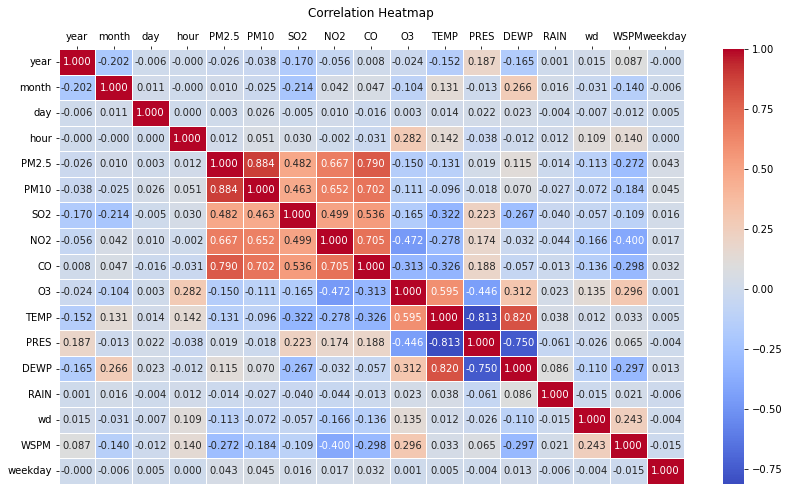

Feature significative:
['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']

Feature che possono essere rimosse:
['year', 'month', 'day', 'hour', 'RAIN', 'wd', 'weekday']


In [40]:
correlation_matrix = data_all.corr(method="pearson")
plt.figure(figsize=(14, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5) 
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Correlation Heatmap', pad=15) 
plt.show()

correlation_matrix1 = correlation_matrix.where(correlation_matrix != 1, 0)
# Definiamo il valore minimo di correlazione per mantenere una feature
threshold = 0.3

true_columns = [col for col in correlation_matrix1.columns if abs(correlation_matrix1[col]).max() >= threshold]
false_columns = [col for col in correlation_matrix1.columns if abs(correlation_matrix1[col]).max() < threshold]

print("Feature significative:")
print(true_columns)

print("\nFeature che possono essere rimosse:")
print(false_columns)

### Test rimozione dei dati

A seguito dell'analisi andremo a rimuovere le feature: 
- `year`
- `month`
- `day`
- `hour`
- `RAIN`
- `wd`
- `weekday`.

In [41]:
Mb = 1_000_000
total_memory_before = (data_all.memory_usage(deep=True).sum())/Mb

data_clean_all = data_ffilled.loc[:, true_columns ] #data_clean = data_all.drop([false_columns, 'station'], axis=1)
data_clean_wan = data_ffilled.loc[ data_ffilled['station'] == dict_names['Wans'], true_columns ]

total_memory_after = (data_clean_all.memory_usage(deep=True).sum())/Mb
print('Memory usage before drop: ' , total_memory_before , ' Mb\nMemory usage after drop: ' , total_memory_after, ' Mb')

Memory usage before drop:  88.115832  Mb
Memory usage after drop:  37.027584  Mb


Dai risultati precedenti, si ha che il modello (addestrato sui dati di Wanshou Xigong) con coefficiente $R^2$ più alto è `gs2`.

Proviamo a riaddestrare `gs2` con il nuovo dataset, sempre **riguardante Wanshou Xigong**, a cui sono state **rimosse le feature precedentemente specificate**.

In [42]:
y_removed = data_clean_wan['TEMP']
X_removed = data_clean_wan.drop(['TEMP'], axis=1)

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_removed, y_removed, test_size=1/3, random_state=42)

from sklearn.base import clone # crea copia del modello gs2
gs2Clone = clone(gs2.best_estimator_)
gs2Clone.fit(X_train_r, y_train_r)
print_eval_all(X_train_r, y_train_r, X_val_r, y_val_r, gs2Clone);

   ----------Training----------
   Mean squared error: 11.525
       Relative error: 0.90750%
R-squared coefficient: 0.91126

   --------Validation----------
   Mean squared error: 11.33
       Relative error: 0.89893%
R-squared coefficient: 0.9123


Notiamo che il coefficiente $R^2$ è 
 - circa 0.94 sul validation set **con** le feature considerate poco rilevanti
 - circa 0.91 sul validation set **senza** le feature considerate poco rilevanti

### Extra: predizioni vs valori inseriti dal metodo fillna(method="ffill") (zona Wanshou Xigong)

All'inizio di questo notebook, abbiamo creato una copia del dataset nella quale abbiamo sostituito i valori NaN della feature `TEMP` con i valori restituiti dal metodo `fillna()`.

Ora proviamo a valutare quanto differiscono le previsioni fatte dal modello `gs2` sui valori NaN della feature `TEMP` (addestrato senza di essi), rispetto ai valori riempiti dal metodo `fillna()`.

Creiamo un nuovo dataset che include solo le righe aventi temperatura NaN nel dataset originale, mentre per le altre feature usiamo i valori inseriti dal metodo `fillna()`.

In [43]:
condition = (data_all['TEMP'].isna()) & (data_all['station'] == dict_names['Wans']) 
# seleziona le righe che hanno TEMP = NaN
drop_columns = ["TEMP", "station"]
data_empty = data_ffilled.loc[condition]
data_empty

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,weekday
date,,,,,,,,,,,,,,,,,,
2015-02-18 07:00:00,2015,2,18,7,16.0,16.0,11.0,31.0,400.0,54.0,276.1500,1026.0,261.05,0.0,270.0,1.1,Wanshouxigong,2
2016-09-14 15:00:00,2016,9,14,15,74.0,78.0,6.0,19.0,800.0,187.0,302.6500,1010.6,290.15,0.0,225.0,3.1,Wanshouxigong,2
2016-09-25 19:00:00,2016,9,25,19,174.0,174.0,3.0,77.0,2200.0,52.0,299.3500,1009.0,292.75,0.0,45.0,1.3,Wanshouxigong,6
2016-09-25 20:00:00,2016,9,25,20,162.0,162.0,3.0,63.0,1800.0,73.0,299.3500,1009.0,292.75,0.0,45.0,1.3,Wanshouxigong,6
2016-09-25 21:00:00,2016,9,25,21,100.0,100.0,3.0,32.0,1300.0,126.0,299.3500,1009.0,292.75,0.0,45.0,1.3,Wanshouxigong,6
2016-09-25 22:00:00,2016,9,25,22,89.0,89.0,3.0,28.0,1200.0,108.0,299.3500,1009.0,292.75,0.0,45.0,1.3,Wanshouxigong,6
2016-09-25 23:00:00,2016,9,25,23,87.0,87.0,3.0,34.0,1200.0,85.0,299.3500,1009.0,292.75,0.0,45.0,1.3,Wanshouxigong,6
2016-09-26 00:00:00,2016,9,26,0,85.0,85.0,3.0,34.0,1200.0,61.0,299.3500,1009.0,292.75,0.0,45.0,2.4,Wanshouxigong,0
2017-01-10 08:00:00,2017,1,10,8,7.0,9.0,4.0,24.0,1000.0,48.0,271.7375,1026.0,255.85,0.0,315.0,2.6,Wanshouxigong,1


In [44]:
# rimuove colonne meno rilevanti, oltre a TEMP e station
data_empty_X_val = data_empty.drop( drop_columns, axis=1).drop( false_columns, axis=1)
data_empty_y_val = data_empty['TEMP']
data_empty_X_val

,PM2.5,PM10,SO2,NO2,CO,O3,PRES,DEWP,WSPM
date,,,,,,,,,
2015-02-18 07:00:00,16.0,16.0,11.0,31.0,400.0,54.0,1026.0,261.05,1.1
2016-09-14 15:00:00,74.0,78.0,6.0,19.0,800.0,187.0,1010.6,290.15,3.1
2016-09-25 19:00:00,174.0,174.0,3.0,77.0,2200.0,52.0,1009.0,292.75,1.3
2016-09-25 20:00:00,162.0,162.0,3.0,63.0,1800.0,73.0,1009.0,292.75,1.3
2016-09-25 21:00:00,100.0,100.0,3.0,32.0,1300.0,126.0,1009.0,292.75,1.3
2016-09-25 22:00:00,89.0,89.0,3.0,28.0,1200.0,108.0,1009.0,292.75,1.3
2016-09-25 23:00:00,87.0,87.0,3.0,34.0,1200.0,85.0,1009.0,292.75,1.3
2016-09-26 00:00:00,85.0,85.0,3.0,34.0,1200.0,61.0,1009.0,292.75,2.4
2017-01-10 08:00:00,7.0,9.0,4.0,24.0,1000.0,48.0,1026.0,255.85,2.6


Adesso riaddestriamo il modello con il nuovo dataset di cui sopra, 

ottieniamo le predizioni e le statistiche riguardo la differenza di tali valori.

In [45]:
preds = gs2Clone.predict(data_empty_X_val)

# la differenza tra valori filled e predetti, in media, è di 0.71 °C
(data_empty_y_val - preds).describe()

count    19.000000
mean      0.715661
std       1.960795
min      -3.592856
25%       0.603584
50%       1.070857
75%       1.530677
max       4.123637
Name: TEMP, dtype: float64

Adesso rappresentiamo i risultati precedenti in un grafico a dispersione.

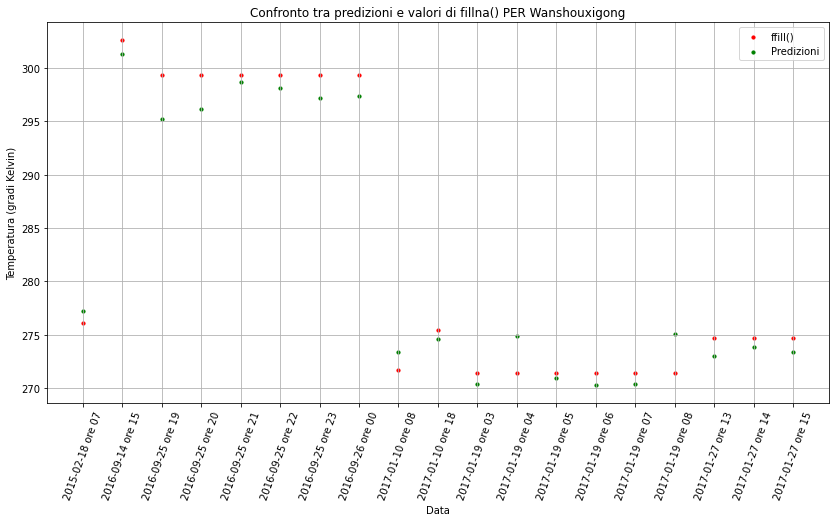

In [46]:
temp = data_ffilled.loc[condition, 'TEMP']
preds = pd.Series(preds, index=data_empty.index)

def plotDataDiff(temp, preds, city_name):
    plt.figure(figsize=(14, 7))
    plt.scatter(data_empty.index.strftime("%Y-%m-%d ore %H"), temp, label="ffill()", c="red", s=10)
    plt.scatter(data_empty.index.strftime("%Y-%m-%d ore %H"), preds, label="Predizioni", c="green", s=10)
    plt.title("Confronto tra predizioni e valori di fillna() PER " + city_name)
    plt.xlabel('Data')
    plt.ylabel('Temperatura (gradi Kelvin)')
    plt.xticks(rotation=70) # ruota etichette di asse x per leggibilità maggiore
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1)) 
    plt.grid(True)
    
plotDataDiff(temp, preds, dict_names['Wans'])

Notiamo che la **differenza media** tra i valori predetti dal modello e i valori restituiti dal metodo `fillna()`,

come mostrato dal metodo `describe()`, è di circa 0.71 Kelvin (che equivalgono a 0.71 °C), ma nel complesso, le predizioni si avvicinano abbastanza ai valori di `fillna()`.

### Extra: predizioni vs valori inseriti dal metodo fillna(method="ffill") (le altre zone di Pechino/Beijing)

Ora proviamo a ripetere lo stesso utilizzando i dati di `fillna()` delle altre zone, confrontandoli con le previsioni del modello `gs2`.

In [47]:
results = {}

for city in dict_names.values():
    if city != dict_names['Wans']:
        condition2 = (data_all['TEMP'].isna()) & (data_all['station'] == city) 
        data_empty = data_ffilled.loc[condition2]
        # rimuove colonne meno rilevanti, oltre a TEMP e station
        data_empty_X_val2 = data_empty.drop( drop_columns, axis=1).drop( false_columns, axis=1)
        data_empty_y_val2 = data_empty['TEMP']

        preds2 = gs2Clone.predict(data_empty_X_val2)
        results[city] = (data_empty_y_val2 - preds2).describe()

In [48]:
results_all_zones = pd.DataFrame(results).T
results_all_zones['mean'].sort_values(ascending = False)

Dongsi          0.916605
Nongzhanguan    0.376320
Wanliu          0.347989
Tiantan         0.259077
Shunyi         -0.239287
Aotizhongxin   -0.314235
Gucheng        -0.820263
Changping      -1.775414
Dingling       -2.430154
Guanyuan       -2.895363
Huairou        -2.958220
Name: mean, dtype: float64

In [49]:
results_all_zones['mean'].mean()

-0.8666314766200354

Notiamo che nelle altre zone di Pechino/Beijing, la **media delle differenze medie** tra predizioni del modello e valori di `fillna()` è molto variabile e si attesta intorno a 0.86 °C.

### Extra: predizioni delle temperature nelle altre zone di Pechino/Beijing

Utilizziamo il modello `gs2` per ottenere predizioni sulle temperature nelle altre zone di Pechino/Beijing, in quanto si è mostrato quello con risultati migliori.

I dati contenuti nel dataset complessivo utilizzato si riferiscono a zone di Pechino/Beijing geograficamente diverse: di conseguenza, le previsioni fornite dal modello potrebbero discostarsi dai valori reali.

Il modello è stato addestrato sui dati della stazione "Wanshou Xigong", nei pressi del Wanshou park, in un centro abitato.

Stazioni di rilevamento in centri abitati:

    Aoti Zhongxin, Dongshi, Guan yuan, Guocheng, Nongzhanguan, Shunyi, Tiantan, Wanliu

Stazioni di rilevamento in zone "meno cementificate":

    Changping, Dingling, Huairou.

Nella parte finale del blocco di codice seguente, creiamo un modello nuovo (con le stesse caratteristiche del modello `gs2`, che è risultato essere il migliore nei test precedenti) per andare a trovare i coefficienti delle feature per ogni città, per poi calcolarne la media. 

L'obbiettivo è ottenere la media dei coefficienti per settarli in un nuovo modello che avrà un'accuratezza generalmente buona in tutte le stazioni di rilevamento, al fine di poter fare previsioni in tutta la superficie di Pechino (oltre 16 mila km$^2$) senza dover dipendere dai dati delle singole stazioni.

In [50]:
results = {}
coefs = { dict_names['Wans']: gs2.best_estimator_.named_steps['regr'].coef_}

for city in dict_names.values():
    y_cities = data_ffilled.loc[ data_ffilled["station"] == city, 'TEMP']
    X_cities = data_ffilled.loc[ data_ffilled["station"] == city].drop(["TEMP", "station"], axis=1)
    
    if city != dict_names["Wans"]: # non testa su Wans
        preds = gs2.best_estimator_.predict(X_cities)
        print("\n\nzona:", city,  "\nmedia delle differenze di temperatura in data_ffilled e temperatura dal modello:",
             (y_cities - preds).mean())
        results[city] = print_eval(X_cities, y_cities, gs2.best_estimator_)

        model = Pipeline([
            ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
            ("scale", StandardScaler()),
            ("regr", LinearRegression())
        ])
        model.fit(X_cities, y_cities)
        coefs[city] = model.named_steps['regr'].coef_
    
    # decommentare la linea seguente per mostrare in un grafico le previsioni del modello
    #plotMeanFeatureByDateAndCity("TEMP", data_ffilled.loc[ data_ffilled["station"] == city], city, getPredictions(X, gs.best_estimator_))



zona: Aotizhongxin 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.4925528197720958
   Mean squared error: 9.5867
       Relative error: 0.83272%
R-squared coefficient: 0.92624


zona: Changping 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.7933623532304979
   Mean squared error: 10.529
       Relative error: 0.88444%
R-squared coefficient: 0.91853


zona: Dingling 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -1.029230970200354
   Mean squared error: 12.02
       Relative error: 0.93998%
R-squared coefficient: 0.907


zona: Dongsi 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: 0.2268648181007662
   Mean squared error: 11.499
       Relative error: 0.82905%
R-squared coefficient: 0.91244


zona: Guanyuan 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.4874238743273585
   Mean squared error: 9.7001
     

Otteniamo un nuovo dataframe in cui inseriamo le performance di un modello identico a `gs2` addestrato sui dati delle singole città, insieme ai risultati di `gs2`, addestrato sui dati di Wanshou Xigong.

In [51]:
results[dict_names['Wans']] = resGs2 # ottiene i risultati di gs2
results_cities = pd.DataFrame(results, index=['MSE', 'err rel', "r2"]).T.sort_values("r2", ascending = False)
results_cities

,MSE,err rel,r2
Wanshouxigong,7.787839,0.007505,0.939715
Nongzhanguan,8.261673,0.007827,0.937092
Tiantan,8.603353,0.007783,0.934490
Shunyi,9.723419,0.008341,0.926287
Aotizhongxin,9.586673,0.008327,0.926241
Gucheng,9.496292,0.008369,0.925569
Guanyuan,9.700071,0.008308,0.925369
Wanliu,10.169916,0.008449,0.921031
Changping,10.528786,0.008844,0.918534
Dongsi,11.498693,0.008291,0.912444


### Indice di similarità tra città

Calcoliamo un "indice di similarità" tra le altre città e Wanshou Xigong (che avrà similarità = 1 con sé stessa):

maggiore è l'accuratezza del modello addestrato su Wanshou Xigong sui dati delle altre città, più queste città sono simili ad essa, quindi
 - indice di similarità vicino a 0: similarità bassa
 - indice di similarità vicino a 1: similarità alta

Calcoliamo il rapporto tra MSE, errore relativo e $R^2$ del modello addestrato su Wanshou Xigong e gli stessi valori delle altre città, poi otteniamo la media di questi tre valori, memorizzata nel dataframe seguente nella colonna `similarity %`.

In [52]:
results_cities_similarity = pd.DataFrame()
results_cities_similarity['MSE'] = resGs2[0] / results_cities.loc[ results_cities.index != dict_names['Wans'] , 'MSE']
results_cities_similarity['err rel'] = resGs2[1] / results_cities.loc[ results_cities.index != dict_names['Wans'] , 'err rel']
results_cities_similarity['r2'] = results_cities.loc[ results_cities.index != dict_names['Wans'] , 'r2'] / resGs2[2]

# media dei 3 valori precedenti
results_cities_similarity['similarity %'] = results_cities_similarity.mean(axis=1).apply(lambda x: x * 100)
results_cities_similarity.sort_values("similarity %", ascending=False)

,MSE,err rel,r2,similarity %
Nongzhanguan,0.942647,0.958899,0.997209,96.625148
Tiantan,0.905210,0.964382,0.994440,95.467736
Gucheng,0.820093,0.896795,0.984947,90.061147
Aotizhongxin,0.812361,0.901304,0.985662,89.977561
Guanyuan,0.802864,0.903430,0.984734,89.700930
Shunyi,0.800936,0.899768,0.985711,89.547172
Wanliu,0.765772,0.888329,0.980118,87.807282
Changping,0.739671,0.848601,0.977460,85.524390
Dongsi,0.677280,0.905291,0.970979,85.118376
Dingling,0.647910,0.798455,0.965182,80.384907


Dai risultati, aspettavamo che città più distanti da Wanshou Xigong avessero similarità minore, infatti:

 - Nongzhanguan è a circa 10 km in linea d'aria più a est da Wanshou Xigong e ha un indice di similarità del 96.6%
 - Shunyi è a circa 45 km in linea d'aria più a est da Wanshou Xigong e ha un indice di similarità del 89.5%
 - Huairou è a circa 65 km in linea d'aria più a nord da Wanshou Xigong e ha un indice di similarità di circa 71.6%.

### Coefficienti polinomiali del modello "migliore"

Ottieniamo i coefficienti delle features polinomiali per ogni città, addestrate tutte con lo stesso modello copia di `gs2`.

In [53]:
coefs_df = pd.DataFrame(coefs, index=model.named_steps['poly'].get_feature_names_out()).T
coefs_df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,RAIN^2,RAIN wd,RAIN WSPM,RAIN weekday,wd^2,wd WSPM,wd weekday,WSPM^2,WSPM weekday,weekday^2
Wanshouxigong,100.425073,350.406520,39.994703,-158.061635,256.857421,-467.808763,-215.474199,-257.251835,163.806934,-292.171567,...,0.567306,0.144701,0.020991,-0.268201,-0.109581,-0.049107,0.030282,-1.073737,0.040454,0.073116
Aotizhongxin,816.258891,170.087217,130.785060,50.306040,64.297738,-81.683012,-74.818657,-727.217124,-2.184069,-190.379872,...,1.051610,0.104046,-0.287312,-0.265421,-0.153586,-0.275450,0.053941,-1.390134,-0.068172,0.015517
Changping,682.166828,309.733351,248.399994,57.312262,75.524055,-69.525661,-492.693361,181.541663,-534.406808,-445.717835,...,0.516140,-0.134071,-0.020440,-0.199972,-1.100232,0.436243,0.065543,-1.051761,-0.071743,0.134052
Dingling,691.964516,502.490733,203.676091,-31.507886,-129.439357,23.228059,-18.313071,-648.279941,254.401768,-382.839679,...,0.384720,-0.107745,0.076706,-0.170788,-1.523094,0.422988,0.050289,-1.503243,-0.135477,0.214860
Dongsi,434.273911,334.424393,151.964783,-65.853508,-295.861088,-10.105954,-192.369183,-213.152672,160.755104,-37.107238,...,0.590607,-0.005294,-0.097867,-0.132953,0.080798,0.038444,-0.119927,-1.025673,-0.017499,0.060940
Guanyuan,1001.752316,164.105606,160.107804,-73.882386,-170.834351,123.309467,-257.750646,-354.459967,73.275756,-142.749499,...,0.882124,0.064233,-0.234605,-0.246635,0.025117,-0.092780,0.019187,-1.415101,-0.007930,-0.017793
Gucheng,1931.744669,566.054222,171.605473,-69.351336,-416.767670,-99.495159,-446.336134,-299.965350,339.216545,-534.527739,...,0.542386,0.079703,0.005073,-0.243344,-0.779762,0.158387,0.075017,-0.953566,0.010910,-0.019062
Huairou,1326.116813,653.921290,357.406731,27.596056,-295.141235,126.050098,-172.826832,-224.394470,13.247803,-109.488059,...,0.601105,0.074319,0.037135,-0.050958,-2.054160,-0.016017,0.036443,-1.294266,0.133613,0.201041
Nongzhanguan,-573.530840,223.085406,166.238497,41.744737,-112.135211,65.663806,-56.094957,-570.588823,-182.669803,-385.515963,...,0.720604,-0.016061,-0.140633,-0.125135,0.433915,0.008902,-0.117041,-0.896092,-0.012892,-0.010203
Shunyi,1179.637501,662.207722,195.872573,-82.224626,-12.991441,-392.139921,83.352388,-93.473507,87.301744,222.384845,...,0.565563,0.023301,0.005510,0.002064,-1.330533,0.428991,-0.188986,-1.376281,-0.022429,0.132288


Ora calcoliamo la media del coefficiente di ogni feature polinomiale.

In [54]:
best_coefs = coefs_df.mean()
best_coefs

year            682.151417
month           392.927481
day             171.265394
hour            -17.221292
PM2.5          -122.598801
                   ...    
wd WSPM           0.101943
wd weekday       -0.006975
WSPM^2           -1.194733
WSPM weekday     -0.008580
weekday^2         0.059444
Length: 152, dtype: float64

Ora settiamo i coefficienti ottenuti qui sopra in un nuovo modello chiamato `best_model`, con le stesse caratteristiche di `gs2`, per ottenere un modello capace di fare previsioni in tutta l'area di Pechino/Beijing.

In [55]:
results2 = {}
best_model = Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
best_model.fit(X, y) # fitting fittizio
best_model.named_steps['regr'].coef_ = best_coefs

for city in dict_names.values():
    y_cities = data_ffilled.loc[ data_ffilled["station"] == city, 'TEMP']
    X_cities = data_ffilled.loc[ data_ffilled["station"] == city].drop(["TEMP", "station"], axis=1)

    preds = best_model.predict(X_cities)
    print("\n\nzona:", city,  "\nmedia delle differenze di temperatura in data_ffilled e temperatura dal modello:",
         (y_cities - preds).mean())
    results2[city] = print_eval(X_cities, y_cities, best_model)



zona: Aotizhongxin 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.382362570927283
   Mean squared error: 9.3037
       Relative error: 0.82760%
R-squared coefficient: 0.92842


zona: Changping 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.8210990984126855
   Mean squared error: 9.6432
       Relative error: 0.85582%
R-squared coefficient: 0.92539


zona: Dingling 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -1.2438071886692483
   Mean squared error: 11.239
       Relative error: 0.92389%
R-squared coefficient: 0.91304


zona: Dongsi 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: 0.23435970276849144
   Mean squared error: 12.4
       Relative error: 0.83158%
R-squared coefficient: 0.90558


zona: Guanyuan 
media delle differenze di temperatura in data_ffilled e temperatura dal modello: -0.32431091999535666
   Mean squared error: 9.4023
  

Ora visualizziamo l'accuratezza di `best_model` nelle varie città.

In [56]:
results_bestmodel_df = pd.DataFrame(results2, index=['MSE', 'err rel', "r2"]).T.sort_values("r2", ascending = False)
results_bestmodel_df

,MSE,err rel,r2
Nongzhanguan,8.040645,0.007783,0.938775
Tiantan,8.390358,0.007845,0.936112
Wanshouxigong,8.624998,0.008010,0.933474
Shunyi,8.862608,0.008016,0.932813
Aotizhongxin,9.303743,0.008276,0.928418
Wanliu,9.252769,0.008195,0.928153
Guanyuan,9.402268,0.008329,0.927660
Gucheng,9.383138,0.008085,0.926456
Changping,9.643244,0.008558,0.925386
Dingling,11.238597,0.009239,0.913042


Calcoliamo la media di MSE, errore relativo e $R^2$ di `best_model`.

In [57]:
results_bestmodel_df.mean()

MSE        9.956927
err rel    0.008460
r2         0.923979
dtype: float64

Calcoliamo la media di MSE, errore relativo e $R^2$ di `gs2`.

In [58]:
results_cities.mean()

MSE        10.224583
err rel     0.008522
r2          0.921910
dtype: float64

Dai risultati qui sopra, si nota che il modello `gs2` ha
 - **errore relativo medio dello 0.85%** sulle altre zone di Pechino/Beijing
 - **coefficiente $R^2$ medio di circa 0.9219**
 
mentre il `best_model` ha
 - **errore relativo medio dello 0.84%** sulle altre zone di Pechino/Beijing
 - **coefficiente $R^2$ medio di circa 0.9239**

Dai risultati precedenti si osserva che la precisione delle predizioni è tutto sommato molto buona.

I risultati migliori sono stati ottenuti a `Nongzhanguan`, mentre i peggiori a `Huairou`, zona montuosa e boscosa nota come "il polmone verde di Pechino" (fonte: [ Wikipedia)](https://it.wikipedia.org/wiki/Huairou).

Ricordiamo che il modello è stato addestrato _esclusivamente_ sui dati di una zona urbana (Wanshou Xigong).